# Time Delayed Neural Network (TDNN) implemented in PyTorch over NARMA10 task

NARMA10 is a benchmark task for testing the ability of a model to learn long-term dependencies. It is a synthetic time series dataset that is generated by a nonlinear autoregressive moving average model of order 10. The task is to predict the next value of the time series given the previous 10 values. The dataset is generated by the following equation:

$$
y(t) = 0.3y(t-1) + 0.05y(t-1)y(t-10) + 1.5x(t-1)x(t-10) + 0.1
$$

where $y(t)$ is the output at time $t$ and $x(t)$ is the input at time $t$. The input $x(t)$ is a random number between 0 and 0.5. The output $y(t)$ is a function of the previous 10 values of $x(t)$ and $y(t)$.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)
data_MG17 = pd.read_csv('MG17.csv', header=None)

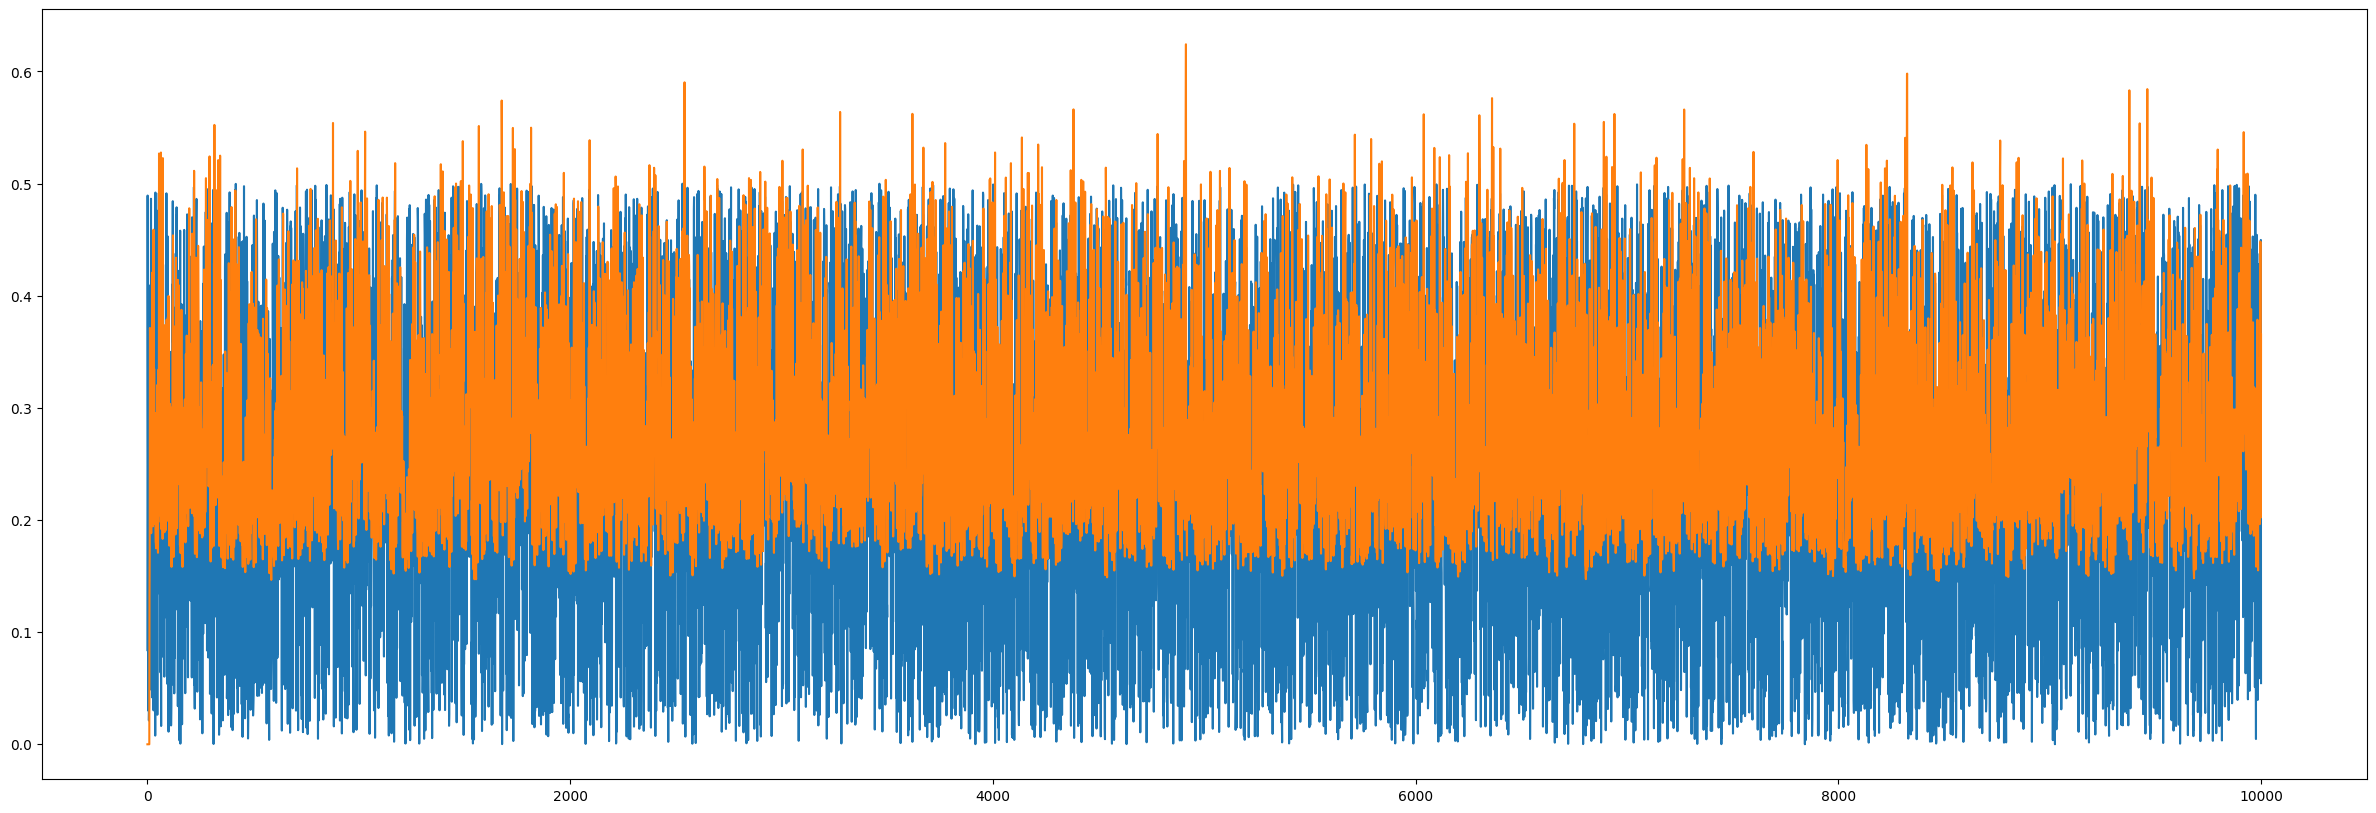

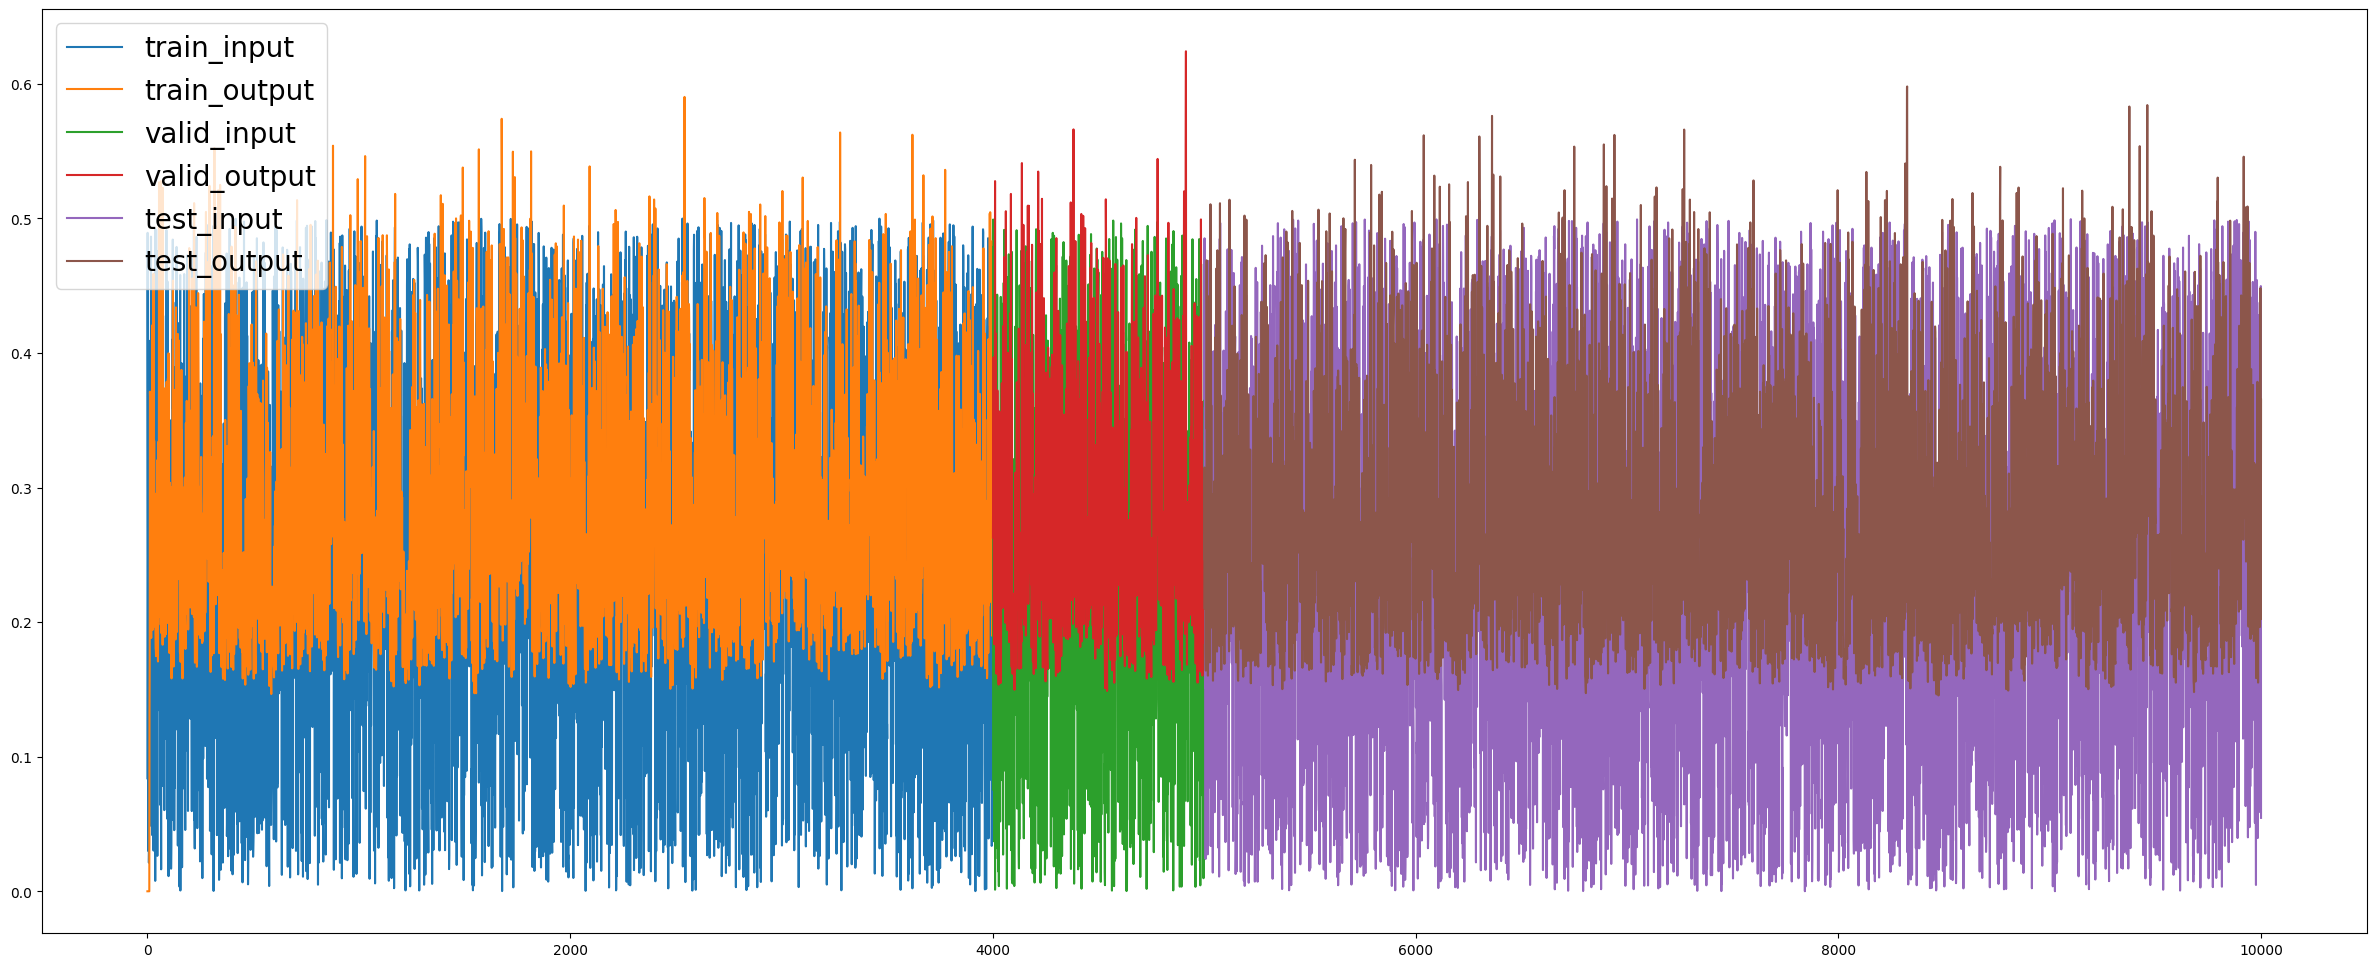

In [13]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [14]:
# divide in train, valid and test the MG17 data, is a single time series of 10000 steps, take 5000 train, 1000 valid and 4000 test
data_MG17.shape
# Index of the timestep is on the columns, so we take first 5000 columns for train, next 1000 for valid and last 4000 for test
train_MG17 = data_MG17.iloc[:, :5000]
valid_MG17 = data_MG17.iloc[:, 5000:6000]
test_MG17 = data_MG17.iloc[:, 6000:]



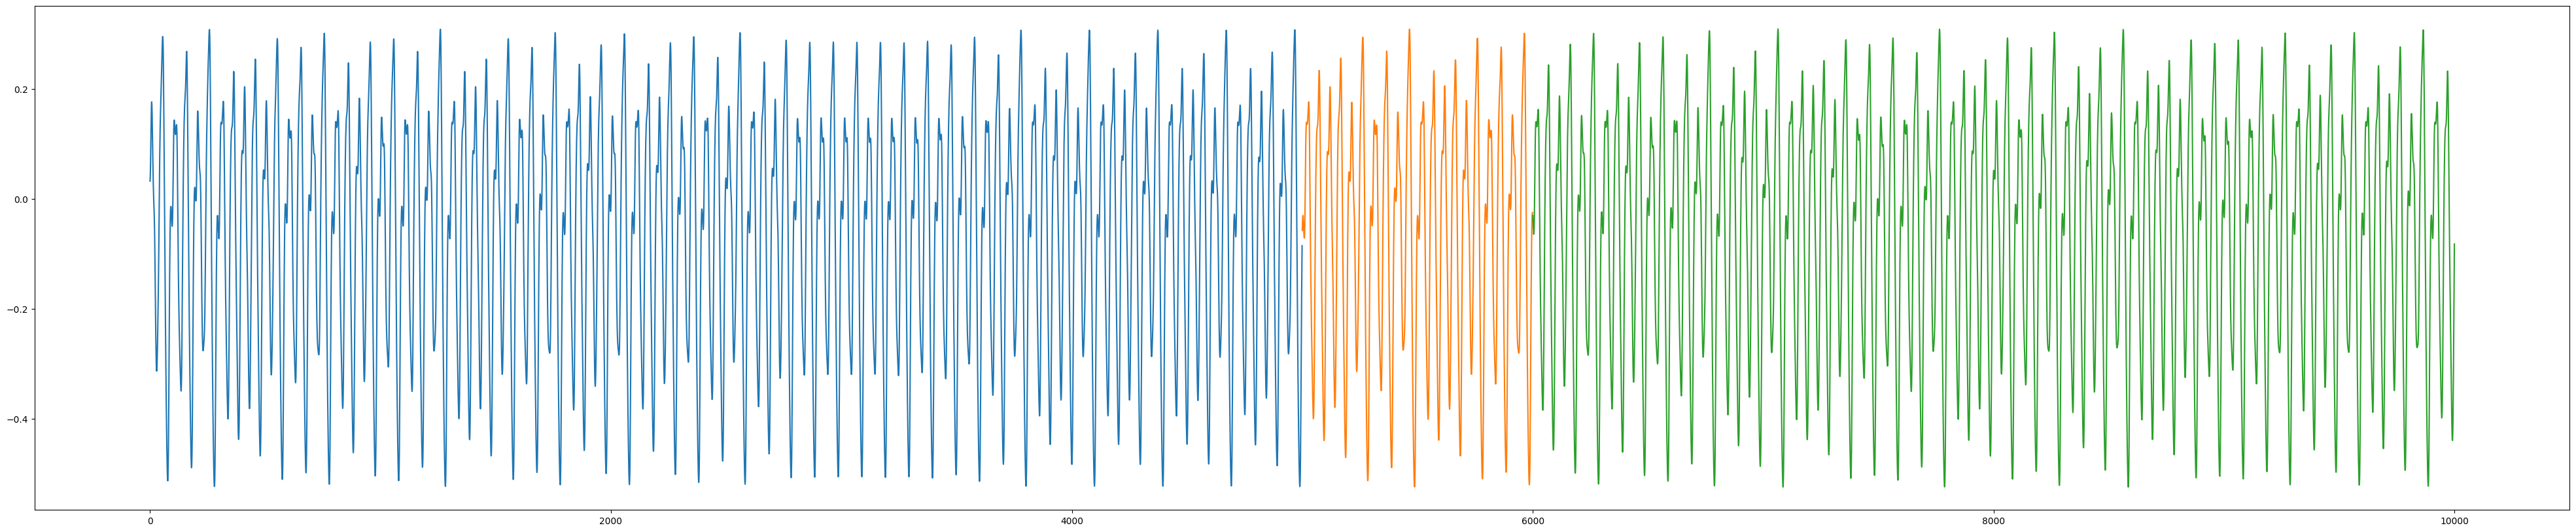

In [15]:
# for each column plot in time series format the data, train, valid and test
plt.figure(figsize=(50,10))
for i in range(0, 1):
    plt.plot(train_MG17.iloc[i])
    plt.plot(valid_MG17.iloc[i])
    plt.plot(test_MG17.iloc[i])

# Best params
- 1 Layer with Kernel size of 39 and Hidden size of 150 with ReLU activation, some obervation are that making too big the size of the Kernel will reach a too slow training and also the attended sequence will be too big.

After the parameters were found a hand fine tuning was made to improve performance on this model because of the performances.

# Researched parameters
- Kernel size = [5, 10, 25, 50, 75]
- Learning rate = [0.001, 0.005, 0.01]
- Hidden size = [50, 100, 150, 200]
- Momentum was fixed to 0.3 from 0.9 because of the performances

In [16]:
# Some advice on TDNN can use 1D convolutions with kernel size 1.
from tqdm import tqdm
from torch import nn
from TimeDelayNeuralNetwork import *

USE_CUDA = False

if USE_CUDA:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    device = 'cpu'


KERNEL_SIZE = 39
PADDING = (KERNEL_SIZE - 1)//2


tdnn = TimeDelayNeuralNetwork(
    input_size=1,
    hidden_size=150,
    output_size=1,
    kernel_size=KERNEL_SIZE,
    dilation=1,
    pool_size=1,
    pool_stride=1,   
    padding=PADDING
)

tdnn.to(device)

print("Current device being used: ", device)

error = nn.MSELoss()

# SGD Optimizer 
lr = 0.015
optimizer = torch.optim.SGD(tdnn.parameters(), lr=lr, momentum=0.3, weight_decay=0.0001)

loss_list = []
valid_loss = []
iteration_list = []
acccuracy_list = []
count = 0

num_epochs = 100

#window_size = 100

# split the data in chunks of window_size, 1,

# Training loop
for i in tqdm(range(num_epochs)):
#    for j in range(window_size, len(train_input)):
    optimizer.zero_grad()
    
    # take current window
    #window_input = train_input[j-window_size:j]
    # take as window_input the whole train_input
    window_input = train_input
    
    # to tensor
    window_input = torch.tensor(window_input.values).float()
    window_input = window_input.unsqueeze(1).unsqueeze(2)


    # check if train_output is a tensor
    if not torch.is_tensor(train_output):
        train_output = torch.tensor(train_output).float()
        target = train_output        
    
    #!TODO current 3D shaped passed is (window_size, 1, 1) we have windows_size (timesteps), batch_size, feature
    
    # forward pass
    output = tdnn(window_input)
    
    # calculate the loss
    loss = error(output, target)
    
    # backwar pass
    loss.backward()
    optimizer.step()
    
    count += 1

    # store the loss
    loss_list.append(loss.item())
    iteration_list.append(count)
    
    # validation
    # go in eval mode
    #tdnn.eval()
    # print("Validating")
    if count % 1 == 0:
        with torch.no_grad():
            
            if device == 'cuda':
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2).cuda()
                valid_output_tensor = torch.tensor(valid_output.values).float().cuda()
            else:
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2)
                valid_output_tensor = torch.tensor(valid_output.values).float()
            
            valid_loss.append(error(tdnn(valid_input_tensor), valid_output_tensor))
        
        print(f"Epoch: {i}, Loss: {loss.item()}, Valid Loss: {valid_loss[-1]}")
            
acccuracy_list=valid_loss

Current device being used:  cpu


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 2/100 [00:00<00:06, 15.95it/s]

Epoch: 0, Loss: 0.03724341467022896, Valid Loss: 0.0334126241505146
Epoch: 1, Loss: 0.03434419631958008, Valid Loss: 0.030031081289052963
Epoch: 2, Loss: 0.030423695221543312, Valid Loss: 0.025596680119633675


  4%|▍         | 4/100 [00:00<00:05, 16.77it/s]

Epoch: 3, Loss: 0.027227044105529785, Valid Loss: 0.023855706676840782


  7%|▋         | 7/100 [00:00<00:04, 18.79it/s]

Epoch: 4, Loss: 0.02412491850554943, Valid Loss: 0.021405277773737907
Epoch: 5, Loss: 0.021645205095410347, Valid Loss: 0.019800754263997078
Epoch: 6, Loss: 0.019852567464113235, Valid Loss: 0.01775912195444107
Epoch: 7, Loss: 0.017933489754796028, Valid Loss: 0.016420690342783928
Epoch: 8, Loss: 0.01665615662932396, Valid Loss: 0.015355176292359829


 12%|█▏        | 12/100 [00:00<00:04, 19.73it/s]

Epoch: 9, Loss: 0.015538414008915424, Valid Loss: 0.01430863980203867
Epoch: 10, Loss: 0.014765467494726181, Valid Loss: 0.013248657807707787
Epoch: 11, Loss: 0.01383750420063734, Valid Loss: 0.012664255686104298
Epoch: 12, Loss: 0.013078107498586178, Valid Loss: 0.012480520643293858
Epoch: 13, Loss: 0.012591640464961529, Valid Loss: 0.011819825507700443

 15%|█▌        | 15/100 [00:00<00:04, 20.19it/s]


Epoch: 14, Loss: 0.012034808285534382, Valid Loss: 0.011410349979996681
Epoch: 15, Loss: 0.011530661024153233, Valid Loss: 0.011162321083247662
Epoch: 16, Loss: 0.011364378966391087, Valid Loss: 0.010802379809319973
Epoch: 17, Loss: 0.011041294783353806, Valid Loss: 0.010518103837966919


 21%|██        | 21/100 [00:01<00:04, 18.87it/s]

Epoch: 18, Loss: 0.010875923559069633, Valid Loss: 0.010573242790997028
Epoch: 19, Loss: 0.010691887699067593, Valid Loss: 0.010264336131513119
Epoch: 20, Loss: 0.010558044537901878, Valid Loss: 0.010237829759716988
Epoch: 21, Loss: 0.010337350890040398, Valid Loss: 0.0102021973580122


 25%|██▌       | 25/100 [00:01<00:04, 17.14it/s]

Epoch: 22, Loss: 0.010336295701563358, Valid Loss: 0.010068988427519798
Epoch: 23, Loss: 0.01023392379283905, Valid Loss: 0.010165490210056305
Epoch: 24, Loss: 0.010188769549131393, Valid Loss: 0.010063138790428638


 27%|██▋       | 27/100 [00:01<00:04, 16.45it/s]

Epoch: 25, Loss: 0.010084589943289757, Valid Loss: 0.009843329899013042
Epoch: 26, Loss: 0.010027223266661167, Valid Loss: 0.009834488853812218
Epoch: 27, Loss: 0.009930834174156189, Valid Loss: 0.00980803556740284
Epoch: 28, Loss: 0.009889771230518818, Valid Loss: 0.009705688804388046


 31%|███       | 31/100 [00:01<00:04, 16.26it/s]

Epoch: 29, Loss: 0.009934098459780216, Valid Loss: 0.009960034862160683
Epoch: 30, Loss: 0.009846195578575134, Valid Loss: 0.009778971783816814
Epoch: 31, Loss: 0.009865316562354565, Valid Loss: 0.009601211175322533
Epoch: 32, Loss: 0.009797653183341026, Valid Loss: 0.009795666672289371


 35%|███▌      | 35/100 [00:01<00:03, 16.59it/s]

Epoch: 33, Loss: 0.009811565279960632, Valid Loss: 0.00977358128875494
Epoch: 34, Loss: 0.009918532334268093, Valid Loss: 0.009733540937304497
Epoch: 35, Loss: 0.009793958626687527, Valid Loss: 0.00985406432300806
Epoch: 36, Loss: 0.009803807362914085, Valid Loss: 0.009617216885089874


 40%|████      | 40/100 [00:02<00:03, 18.61it/s]

Epoch: 37, Loss: 0.009750434197485447, Valid Loss: 0.009620080702006817
Epoch: 38, Loss: 0.009703605435788631, Valid Loss: 0.009819104336202145
Epoch: 39, Loss: 0.009757581166923046, Valid Loss: 0.009596158750355244
Epoch: 40, Loss: 0.009775607846677303, Valid Loss: 0.009660487994551659


 44%|████▍     | 44/100 [00:02<00:03, 18.44it/s]

Epoch: 41, Loss: 0.009783029556274414, Valid Loss: 0.009755406528711319
Epoch: 42, Loss: 0.009659760631620884, Valid Loss: 0.009764119051396847
Epoch: 43, Loss: 0.00968127604573965, Valid Loss: 0.009676608256995678
Epoch: 44, Loss: 0.009765193797647953, Valid Loss: 0.009651804342865944


 48%|████▊     | 48/100 [00:02<00:03, 15.60it/s]

Epoch: 45, Loss: 0.009692099876701832, Valid Loss: 0.009618975222110748
Epoch: 46, Loss: 0.009713218547403812, Valid Loss: 0.009676022455096245
Epoch: 47, Loss: 0.00978457648307085, Valid Loss: 0.00962277315557003


 52%|█████▏    | 52/100 [00:02<00:02, 16.18it/s]

Epoch: 48, Loss: 0.009653708897531033, Valid Loss: 0.009683324955403805
Epoch: 49, Loss: 0.009665137156844139, Valid Loss: 0.00970106478780508
Epoch: 50, Loss: 0.00965341366827488, Valid Loss: 0.00971934013068676
Epoch: 51, Loss: 0.009588867425918579, Valid Loss: 0.0097312917932868


 56%|█████▌    | 56/100 [00:03<00:02, 16.98it/s]

Epoch: 52, Loss: 0.009578220546245575, Valid Loss: 0.009601476602256298
Epoch: 53, Loss: 0.00968816690146923, Valid Loss: 0.009656607173383236
Epoch: 54, Loss: 0.009641412645578384, Valid Loss: 0.009626893326640129
Epoch: 55, Loss: 0.009659123606979847, Valid Loss: 0.009619227610528469


 60%|██████    | 60/100 [00:03<00:02, 18.06it/s]

Epoch: 56, Loss: 0.009689128957688808, Valid Loss: 0.009478569030761719
Epoch: 57, Loss: 0.009659785777330399, Valid Loss: 0.00950969010591507
Epoch: 58, Loss: 0.009698723442852497, Valid Loss: 0.009547322988510132
Epoch: 59, Loss: 0.009714125655591488, Valid Loss: 0.00960403960198164
Epoch: 60, Loss: 0.009699703194200993, Valid Loss: 0.009563319385051727


 65%|██████▌   | 65/100 [00:03<00:01, 19.29it/s]

Epoch: 61, Loss: 0.009580643847584724, Valid Loss: 0.009599683806300163
Epoch: 62, Loss: 0.009620549157261848, Valid Loss: 0.009562999941408634
Epoch: 63, Loss: 0.00958702340722084, Valid Loss: 0.009687671437859535
Epoch: 64, Loss: 0.009608269669115543, Valid Loss: 0.00959048606455326
Epoch: 65, Loss: 0.009583043865859509, Valid Loss: 0.009632325731217861


 70%|███████   | 70/100 [00:03<00:01, 19.73it/s]

Epoch: 66, Loss: 0.009789309464395046, Valid Loss: 0.00969703122973442
Epoch: 67, Loss: 0.009565574117004871, Valid Loss: 0.009659674018621445
Epoch: 68, Loss: 0.00965527631342411, Valid Loss: 0.009647932834923267
Epoch: 69, Loss: 0.009575600735843182, Valid Loss: 0.009633596986532211


 72%|███████▏  | 72/100 [00:04<00:01, 18.35it/s]

Epoch: 70, Loss: 0.009579943493008614, Valid Loss: 0.009564495645463467
Epoch: 71, Loss: 0.009590726345777512, Valid Loss: 0.009598749689757824
Epoch: 72, Loss: 0.009554200805723667, Valid Loss: 0.009609099477529526
Epoch: 73, Loss: 0.00960010290145874, Valid Loss: 0.009658446535468102
Epoch: 74, Loss: 0.009594589471817017, Valid Loss: 0.009501741267740726


 77%|███████▋  | 77/100 [00:04<00:01, 19.19it/s]

Epoch: 75, Loss: 0.009586536325514317, Valid Loss: 0.009496605023741722
Epoch: 76, Loss: 0.00962833035737276, Valid Loss: 0.0095791295170784
Epoch: 77, Loss: 0.009594844654202461, Valid Loss: 0.00946066528558731
Epoch: 78, Loss: 0.009590600617229939, Valid Loss: 0.009551865980029106
Epoch: 79, Loss: 0.00958995707333088, Valid Loss: 0.0095918457955122


 82%|████████▏ | 82/100 [00:04<00:00, 19.55it/s]

Epoch: 80, Loss: 0.00960862822830677, Valid Loss: 0.009487089700996876
Epoch: 81, Loss: 0.009541907347738743, Valid Loss: 0.009620610624551773
Epoch: 82, Loss: 0.009522787295281887, Valid Loss: 0.009415357373654842
Epoch: 83, Loss: 0.009544066153466702, Valid Loss: 0.009506500326097012
Epoch: 84, Loss: 0.009526972658932209, Valid Loss: 0.009667576290667057


 90%|█████████ | 90/100 [00:04<00:00, 20.11it/s]

Epoch: 85, Loss: 0.009554856456816196, Valid Loss: 0.00939889159053564
Epoch: 86, Loss: 0.00958362314850092, Valid Loss: 0.009549112990498543
Epoch: 87, Loss: 0.009557805024087429, Valid Loss: 0.00949831586331129
Epoch: 88, Loss: 0.009563056752085686, Valid Loss: 0.009596827439963818
Epoch: 89, Loss: 0.009580133482813835, Valid Loss: 0.009482291527092457


 93%|█████████▎| 93/100 [00:05<00:00, 19.83it/s]

Epoch: 90, Loss: 0.00958216655999422, Valid Loss: 0.00946455541998148
Epoch: 91, Loss: 0.009520701132714748, Valid Loss: 0.00957835465669632
Epoch: 92, Loss: 0.009597551077604294, Valid Loss: 0.009561048820614815
Epoch: 93, Loss: 0.009591685608029366, Valid Loss: 0.009511316195130348


 98%|█████████▊| 98/100 [00:05<00:00, 19.72it/s]

Epoch: 94, Loss: 0.009532366879284382, Valid Loss: 0.009399360977113247
Epoch: 95, Loss: 0.009531434625387192, Valid Loss: 0.00944551546126604
Epoch: 96, Loss: 0.009545364417135715, Valid Loss: 0.009466713294386864
Epoch: 97, Loss: 0.009501377120614052, Valid Loss: 0.009353308007121086
Epoch: 98, Loss: 0.009538757614791393, Valid Loss: 0.009479084052145481


100%|██████████| 100/100 [00:05<00:00, 18.42it/s]

Epoch: 99, Loss: 0.009501749649643898, Valid Loss: 0.009419810958206654


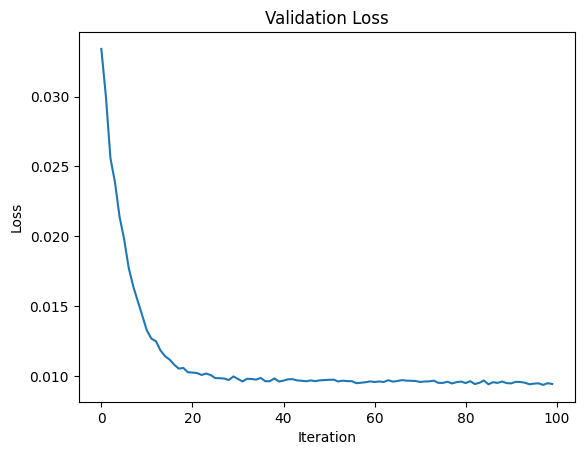

Text(0.5, 1.0, 'Training Loss')

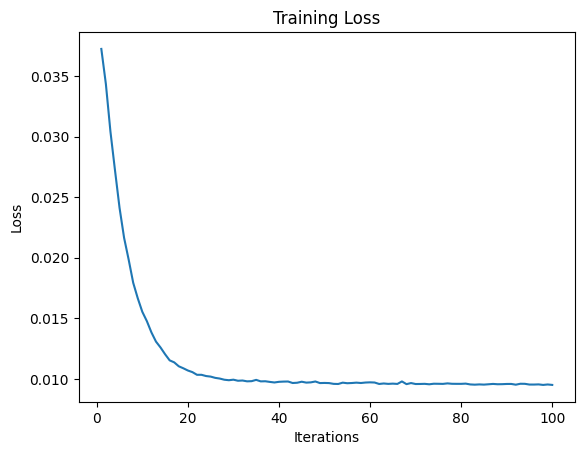

In [17]:
# plot validation loss
plt.plot(acccuracy_list)
plt.title('Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot the loss and validation loss

plt.plot(iteration_list, loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')



# Visualizing the NARMA10 dataset reconstructed by TDNN

In [18]:
# get prediction for training and validation and test
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid = tdnn(valid_input_tensor)

test_input_tensor = torch.Tensor(test_input.values).unsqueeze(1).unsqueeze(2)
output_test = tdnn(test_input_tensor)


Error on the test is:  0.00918207306104429


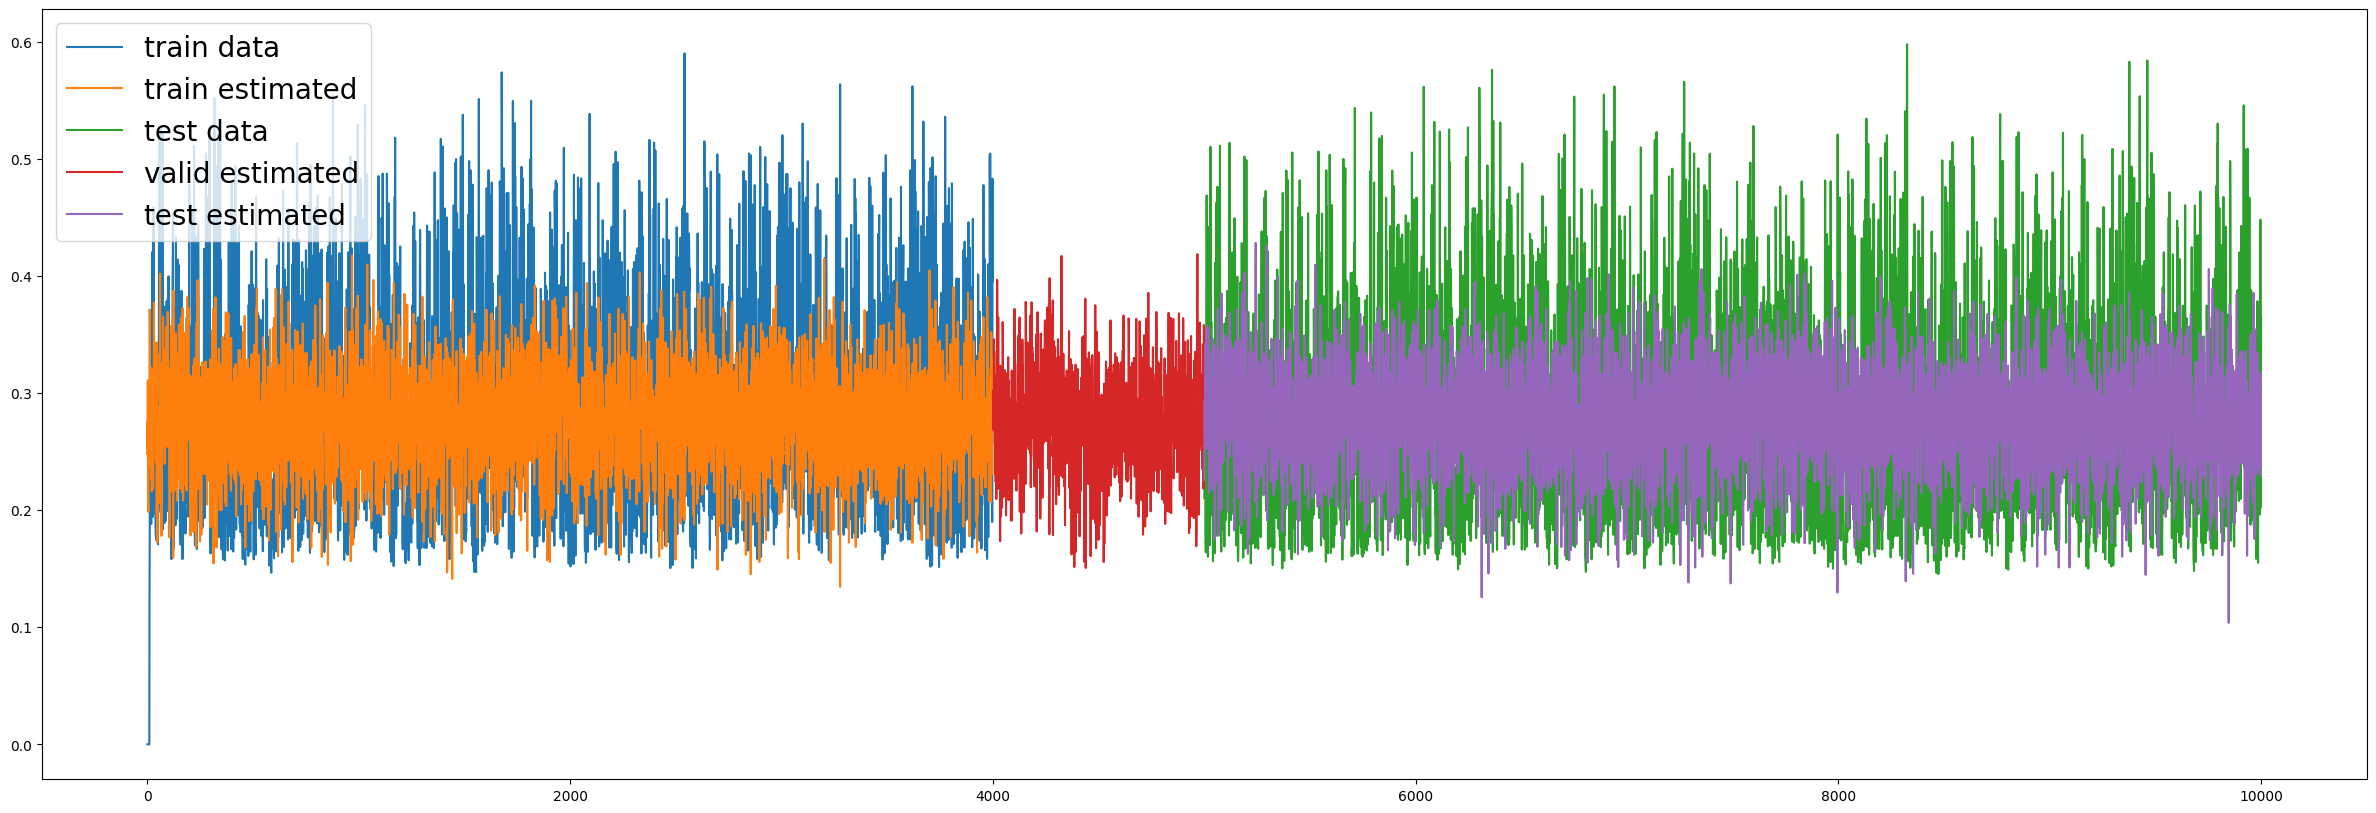

In [19]:

#get prediction for training input
input_train = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(input_train)
# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()
output_test = output_test.detach().numpy()

# converrt the tensor in the numpy array time series taking first only the time serie
#output_train = output_train.squeeze(2).detach().numpy()
# take the first element of the tensor
#output_train = output_train[:,1]

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
plt.plot(output_train)
# add real test and performance on the test
plt.plot(test_output)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])
# after 5000 step put the output_test
plt.plot(np.arange(5000, 10000), output_test[:,0])
plt.legend(['train data', 'train estimated', 'test data', 'valid estimated', 'test estimated'], loc='upper left', fontsize=20)

# Print error for the test is
error_test = np.mean((output_test[:,0] - test_output)**2)
print("Error on the test is: ", error_test)


# Let's try RNN now

In [20]:
from RecurrentNeuralNetwork import *
from tqdm import tqdm

In [21]:
# get the copied data
train_input = train_input_copy
valid_input = valid_input_copy
test_input = test_input_copy

train_output = train_output_copy
valid_output = valid_output_copy
test_output = test_output_copy


In [22]:
rnn = RNN(
    input_size=1,
    hidden_size=100,
    output_size=1,
    num_layers=1
)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
loss = nn.MSELoss()

C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Best params
- 1 Layer with 100 hidden size and lr of 0.001, ReLU activation function and 100 epochs, for this simple model the best results were achieved by simply choosing the right learning rate.

# Researched parameters
Just searched for the best learning rate until a decent error was achieved.
With some probing for the other parameters.

In [23]:
# Training loop for RNN
num_epochs = 100
batch_size = 128
h_out = None
train_loss = []
valid_loss = []

for epoch in tqdm(range(num_epochs)):
    print(f'Epoch {epoch}')
    for i in range(0, len(train_input), batch_size):
        optimizer.zero_grad()
        
        input_batch = torch.Tensor(train_input[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
        output_batch = torch.Tensor(train_output[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
    
        output, h_out = rnn(input_batch, h_out)
        
        h_out = h_out.detach() if h_out is not None else None

        l = loss(output, output_batch)
        
        l.backward()
        optimizer.step()
        

    with torch.no_grad():
        
        valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
        output_valid, _ = rnn(valid_input_tensor, h_out)
        
        val_loss = loss(output_valid, torch.Tensor(valid_output.values).unsqueeze(1).unsqueeze(2))
        
        valid_loss.append(val_loss.item())
                
        train_loss.append(np.mean(l.item()))
        print(f'Validation Loss {val_loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


  1%|          | 1/100 [00:00<00:51,  1.93it/s]

Validation Loss 0.007743475027382374
Epoch 1


  2%|▏         | 2/100 [00:00<00:45,  2.15it/s]

Validation Loss 0.006984411273151636
Epoch 2


  3%|▎         | 3/100 [00:01<00:43,  2.23it/s]

Validation Loss 0.006680659018456936
Epoch 3


  4%|▍         | 4/100 [00:01<00:41,  2.32it/s]

Validation Loss 0.006291352212429047
Epoch 4


  5%|▌         | 5/100 [00:02<00:40,  2.37it/s]

Validation Loss 0.005833717063069344
Epoch 5


  6%|▌         | 6/100 [00:02<00:38,  2.42it/s]

Validation Loss 0.0053678033873438835
Epoch 6


  7%|▋         | 7/100 [00:02<00:38,  2.43it/s]

Validation Loss 0.00497712567448616
Epoch 7


  8%|▊         | 8/100 [00:03<00:38,  2.37it/s]

Validation Loss 0.0047158412635326385
Epoch 8


  9%|▉         | 9/100 [00:03<00:38,  2.37it/s]

Validation Loss 0.004567231051623821
Epoch 9


 10%|█         | 10/100 [00:04<00:39,  2.28it/s]

Validation Loss 0.004514096304774284
Epoch 10


 11%|█         | 11/100 [00:04<00:40,  2.17it/s]

Validation Loss 0.0045070950873196125
Epoch 11


 12%|█▏        | 12/100 [00:05<00:41,  2.11it/s]

Validation Loss 0.004498408176004887
Epoch 12


 13%|█▎        | 13/100 [00:05<00:41,  2.10it/s]

Validation Loss 0.004493393935263157
Epoch 13


 14%|█▍        | 14/100 [00:06<00:41,  2.05it/s]

Validation Loss 0.004489315208047628
Epoch 14


 15%|█▌        | 15/100 [00:06<00:39,  2.13it/s]

Validation Loss 0.004485526587814093
Epoch 15


 16%|█▌        | 16/100 [00:07<00:37,  2.23it/s]

Validation Loss 0.004480515606701374
Epoch 16


 17%|█▋        | 17/100 [00:07<00:37,  2.21it/s]

Validation Loss 0.004477004520595074
Epoch 17


 18%|█▊        | 18/100 [00:08<00:35,  2.30it/s]

Validation Loss 0.004470616113394499
Epoch 18


 19%|█▉        | 19/100 [00:08<00:35,  2.28it/s]

Validation Loss 0.0044610872864723206
Epoch 19


 20%|██        | 20/100 [00:08<00:34,  2.31it/s]

Validation Loss 0.0044508581049740314
Epoch 20


 21%|██        | 21/100 [00:09<00:34,  2.31it/s]

Validation Loss 0.004437107127159834
Epoch 21


 22%|██▏       | 22/100 [00:09<00:33,  2.35it/s]

Validation Loss 0.004411748610436916
Epoch 22


 23%|██▎       | 23/100 [00:10<00:32,  2.40it/s]

Validation Loss 0.004359419923275709
Epoch 23


 24%|██▍       | 24/100 [00:10<00:31,  2.40it/s]

Validation Loss 0.004154837224632502
Epoch 24


 25%|██▌       | 25/100 [00:10<00:31,  2.38it/s]

Validation Loss 0.0037435994017869234
Epoch 25


 26%|██▌       | 26/100 [00:11<00:30,  2.42it/s]

Validation Loss 0.003722364315763116
Epoch 26


 27%|██▋       | 27/100 [00:11<00:31,  2.29it/s]

Validation Loss 0.003708137897774577
Epoch 27


 28%|██▊       | 28/100 [00:12<00:31,  2.31it/s]

Validation Loss 0.0036963874008506536
Epoch 28


 29%|██▉       | 29/100 [00:12<00:31,  2.28it/s]

Validation Loss 0.003684021532535553
Epoch 29


 30%|███       | 30/100 [00:13<00:30,  2.27it/s]

Validation Loss 0.0036678665783256292
Epoch 30


 31%|███       | 31/100 [00:13<00:30,  2.28it/s]

Validation Loss 0.003659529611468315
Epoch 31


 32%|███▏      | 32/100 [00:14<00:31,  2.14it/s]

Validation Loss 0.0036597084254026413
Epoch 32


 33%|███▎      | 33/100 [00:14<00:31,  2.16it/s]

Validation Loss 0.00365448952652514
Epoch 33


 34%|███▍      | 34/100 [00:15<00:29,  2.24it/s]

Validation Loss 0.003646088996902108
Epoch 34


 35%|███▌      | 35/100 [00:15<00:28,  2.31it/s]

Validation Loss 0.0036337825004011393
Epoch 35


 36%|███▌      | 36/100 [00:15<00:26,  2.38it/s]

Validation Loss 0.0036111120134592056
Epoch 36


 37%|███▋      | 37/100 [00:16<00:26,  2.42it/s]

Validation Loss 0.0035463767126202583
Epoch 37


 38%|███▊      | 38/100 [00:16<00:26,  2.37it/s]

Validation Loss 0.0033523044548928738
Epoch 38


 39%|███▉      | 39/100 [00:17<00:25,  2.41it/s]

Validation Loss 0.0032160445116460323
Epoch 39


 40%|████      | 40/100 [00:17<00:25,  2.35it/s]

Validation Loss 0.0031907635275274515
Epoch 40


 41%|████      | 41/100 [00:17<00:25,  2.32it/s]

Validation Loss 0.003178440034389496
Epoch 41


 42%|████▏     | 42/100 [00:18<00:25,  2.28it/s]

Validation Loss 0.0031656704377382994
Epoch 42


 43%|████▎     | 43/100 [00:18<00:24,  2.35it/s]

Validation Loss 0.0031633558683097363
Epoch 43


 44%|████▍     | 44/100 [00:19<00:23,  2.35it/s]

Validation Loss 0.0031592119485139847
Epoch 44


 45%|████▌     | 45/100 [00:19<00:24,  2.26it/s]

Validation Loss 0.00315646780654788
Epoch 45


 46%|████▌     | 46/100 [00:20<00:23,  2.29it/s]

Validation Loss 0.0031514419242739677
Epoch 46


 47%|████▋     | 47/100 [00:20<00:23,  2.29it/s]

Validation Loss 0.0031444388441741467
Epoch 47


 48%|████▊     | 48/100 [00:20<00:22,  2.34it/s]

Validation Loss 0.0031309525948017836
Epoch 48


 49%|████▉     | 49/100 [00:21<00:22,  2.26it/s]

Validation Loss 0.003122227732092142
Epoch 49


 50%|█████     | 50/100 [00:21<00:21,  2.36it/s]

Validation Loss 0.003107729833573103
Epoch 50


 51%|█████     | 51/100 [00:22<00:21,  2.24it/s]

Validation Loss 0.0031023663468658924
Epoch 51


 52%|█████▏    | 52/100 [00:22<00:20,  2.29it/s]

Validation Loss 0.003096614498645067
Epoch 52


 53%|█████▎    | 53/100 [00:23<00:20,  2.32it/s]

Validation Loss 0.003092191182076931
Epoch 53


 54%|█████▍    | 54/100 [00:23<00:19,  2.35it/s]

Validation Loss 0.0030812076292932034
Epoch 54


 55%|█████▌    | 55/100 [00:23<00:19,  2.36it/s]

Validation Loss 0.0030668219551444054
Epoch 55


 56%|█████▌    | 56/100 [00:24<00:19,  2.31it/s]

Validation Loss 0.0030524868052452803
Epoch 56


 57%|█████▋    | 57/100 [00:24<00:19,  2.26it/s]

Validation Loss 0.0030415495857596397
Epoch 57


 58%|█████▊    | 58/100 [00:25<00:18,  2.24it/s]

Validation Loss 0.0030230656266212463
Epoch 58


 59%|█████▉    | 59/100 [00:25<00:17,  2.31it/s]

Validation Loss 0.0029959145467728376
Epoch 59


 60%|██████    | 60/100 [00:26<00:17,  2.26it/s]

Validation Loss 0.0029777921736240387
Epoch 60


 61%|██████    | 61/100 [00:26<00:17,  2.23it/s]

Validation Loss 0.002940448699519038
Epoch 61


 62%|██████▏   | 62/100 [00:27<00:16,  2.28it/s]

Validation Loss 0.002752866130322218
Epoch 62


 63%|██████▎   | 63/100 [00:27<00:15,  2.34it/s]

Validation Loss 0.002558352891355753
Epoch 63


 64%|██████▍   | 64/100 [00:27<00:15,  2.39it/s]

Validation Loss 0.0024831099435687065
Epoch 64


 65%|██████▌   | 65/100 [00:28<00:14,  2.41it/s]

Validation Loss 0.0024639873299747705
Epoch 65


 66%|██████▌   | 66/100 [00:28<00:13,  2.43it/s]

Validation Loss 0.0024296846240758896
Epoch 66


 67%|██████▋   | 67/100 [00:29<00:14,  2.36it/s]

Validation Loss 0.0024188528768718243
Epoch 67


 68%|██████▊   | 68/100 [00:29<00:13,  2.38it/s]

Validation Loss 0.002367800334468484
Epoch 68


 69%|██████▉   | 69/100 [00:29<00:12,  2.44it/s]

Validation Loss 0.0023542961571365595
Epoch 69


 70%|███████   | 70/100 [00:30<00:12,  2.42it/s]

Validation Loss 0.002323890570551157
Epoch 70


 71%|███████   | 71/100 [00:30<00:12,  2.41it/s]

Validation Loss 0.0022859000600874424
Epoch 71


 72%|███████▏  | 72/100 [00:31<00:11,  2.39it/s]

Validation Loss 0.0022741255816072226
Epoch 72


 73%|███████▎  | 73/100 [00:31<00:11,  2.42it/s]

Validation Loss 0.0022479586768895388
Epoch 73


 74%|███████▍  | 74/100 [00:32<00:11,  2.21it/s]

Validation Loss 0.0022431754041463137
Epoch 74


 75%|███████▌  | 75/100 [00:32<00:11,  2.19it/s]

Validation Loss 0.0022099006455391645
Epoch 75


 76%|███████▌  | 76/100 [00:33<00:10,  2.22it/s]

Validation Loss 0.0021995871793478727
Epoch 76


 77%|███████▋  | 77/100 [00:33<00:10,  2.16it/s]

Validation Loss 0.002185841090977192
Epoch 77


 78%|███████▊  | 78/100 [00:34<00:10,  2.13it/s]

Validation Loss 0.0021494468674063683
Epoch 78


 79%|███████▉  | 79/100 [00:34<00:09,  2.15it/s]

Validation Loss 0.002154076239094138
Epoch 79


 80%|████████  | 80/100 [00:35<00:09,  2.10it/s]

Validation Loss 0.002110437722876668
Epoch 80


 81%|████████  | 81/100 [00:35<00:08,  2.17it/s]

Validation Loss 0.002159358933568001
Epoch 81


 82%|████████▏ | 82/100 [00:35<00:08,  2.24it/s]

Validation Loss 0.002064566593617201
Epoch 82


 83%|████████▎ | 83/100 [00:36<00:07,  2.29it/s]

Validation Loss 0.002054210752248764
Epoch 83


 84%|████████▍ | 84/100 [00:36<00:06,  2.33it/s]

Validation Loss 0.001640166388824582
Epoch 84


 85%|████████▌ | 85/100 [00:37<00:06,  2.34it/s]

Validation Loss 0.0012628479162231088
Epoch 85


 86%|████████▌ | 86/100 [00:37<00:06,  2.32it/s]

Validation Loss 0.0011839616345241666
Epoch 86


 87%|████████▋ | 87/100 [00:38<00:05,  2.21it/s]

Validation Loss 0.0011152715887874365
Epoch 87


 88%|████████▊ | 88/100 [00:38<00:05,  2.20it/s]

Validation Loss 0.0010710661299526691
Epoch 88


 89%|████████▉ | 89/100 [00:39<00:05,  2.13it/s]

Validation Loss 0.001042317831888795
Epoch 89


 90%|█████████ | 90/100 [00:39<00:04,  2.13it/s]

Validation Loss 0.0010324957547709346
Epoch 90


 91%|█████████ | 91/100 [00:39<00:04,  2.08it/s]

Validation Loss 0.0012363001005724072
Epoch 91


 92%|█████████▏| 92/100 [00:40<00:03,  2.06it/s]

Validation Loss 0.0009691502782516181
Epoch 92


 93%|█████████▎| 93/100 [00:40<00:03,  2.14it/s]

Validation Loss 0.0009391377097927034
Epoch 93


 94%|█████████▍| 94/100 [00:41<00:02,  2.19it/s]

Validation Loss 0.0010005724616348743
Epoch 94


 95%|█████████▌| 95/100 [00:41<00:02,  2.22it/s]

Validation Loss 0.0009166102390736341
Epoch 95


 96%|█████████▌| 96/100 [00:42<00:01,  2.30it/s]

Validation Loss 0.0008564262534491718
Epoch 96


 97%|█████████▋| 97/100 [00:42<00:01,  2.36it/s]

Validation Loss 0.0008224896737374365
Epoch 97


 98%|█████████▊| 98/100 [00:42<00:00,  2.41it/s]

Validation Loss 0.0007937246118672192
Epoch 98


 99%|█████████▉| 99/100 [00:43<00:00,  2.44it/s]

Validation Loss 0.0007499838247895241
Epoch 99


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

Validation Loss 0.0007265901076607406


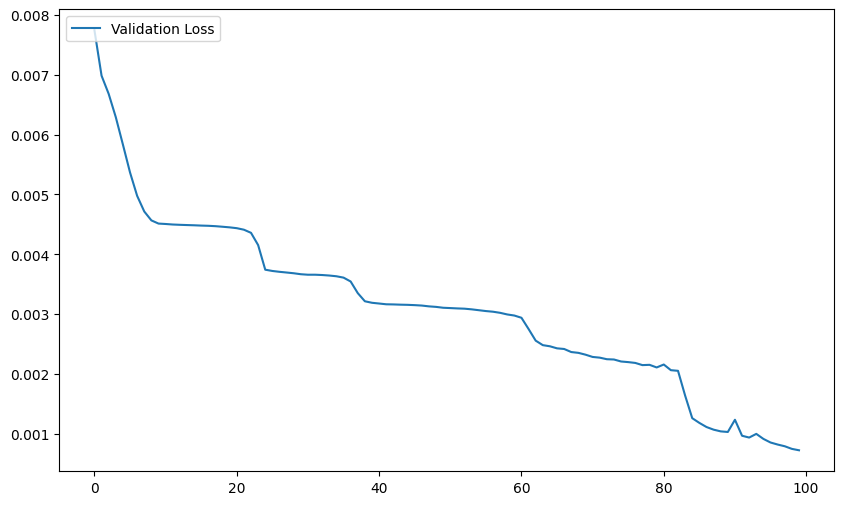

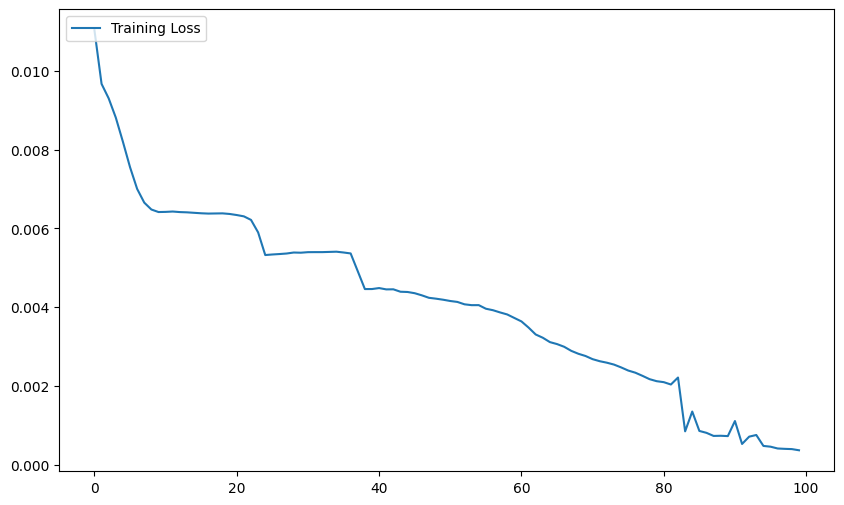

In [24]:
# Show curves validation and training
plt.figure(figsize=(10,6))
plt.plot(valid_loss)
plt.legend(['Validation Loss'], loc='upper left', fontsize=10)

# plot the training loss
plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.legend(['Training Loss'], loc='upper left', fontsize=10)



# Visualizing the NARMA10 dataset reconstructed by RNN

Error on the test is:  0.0007416830634945402


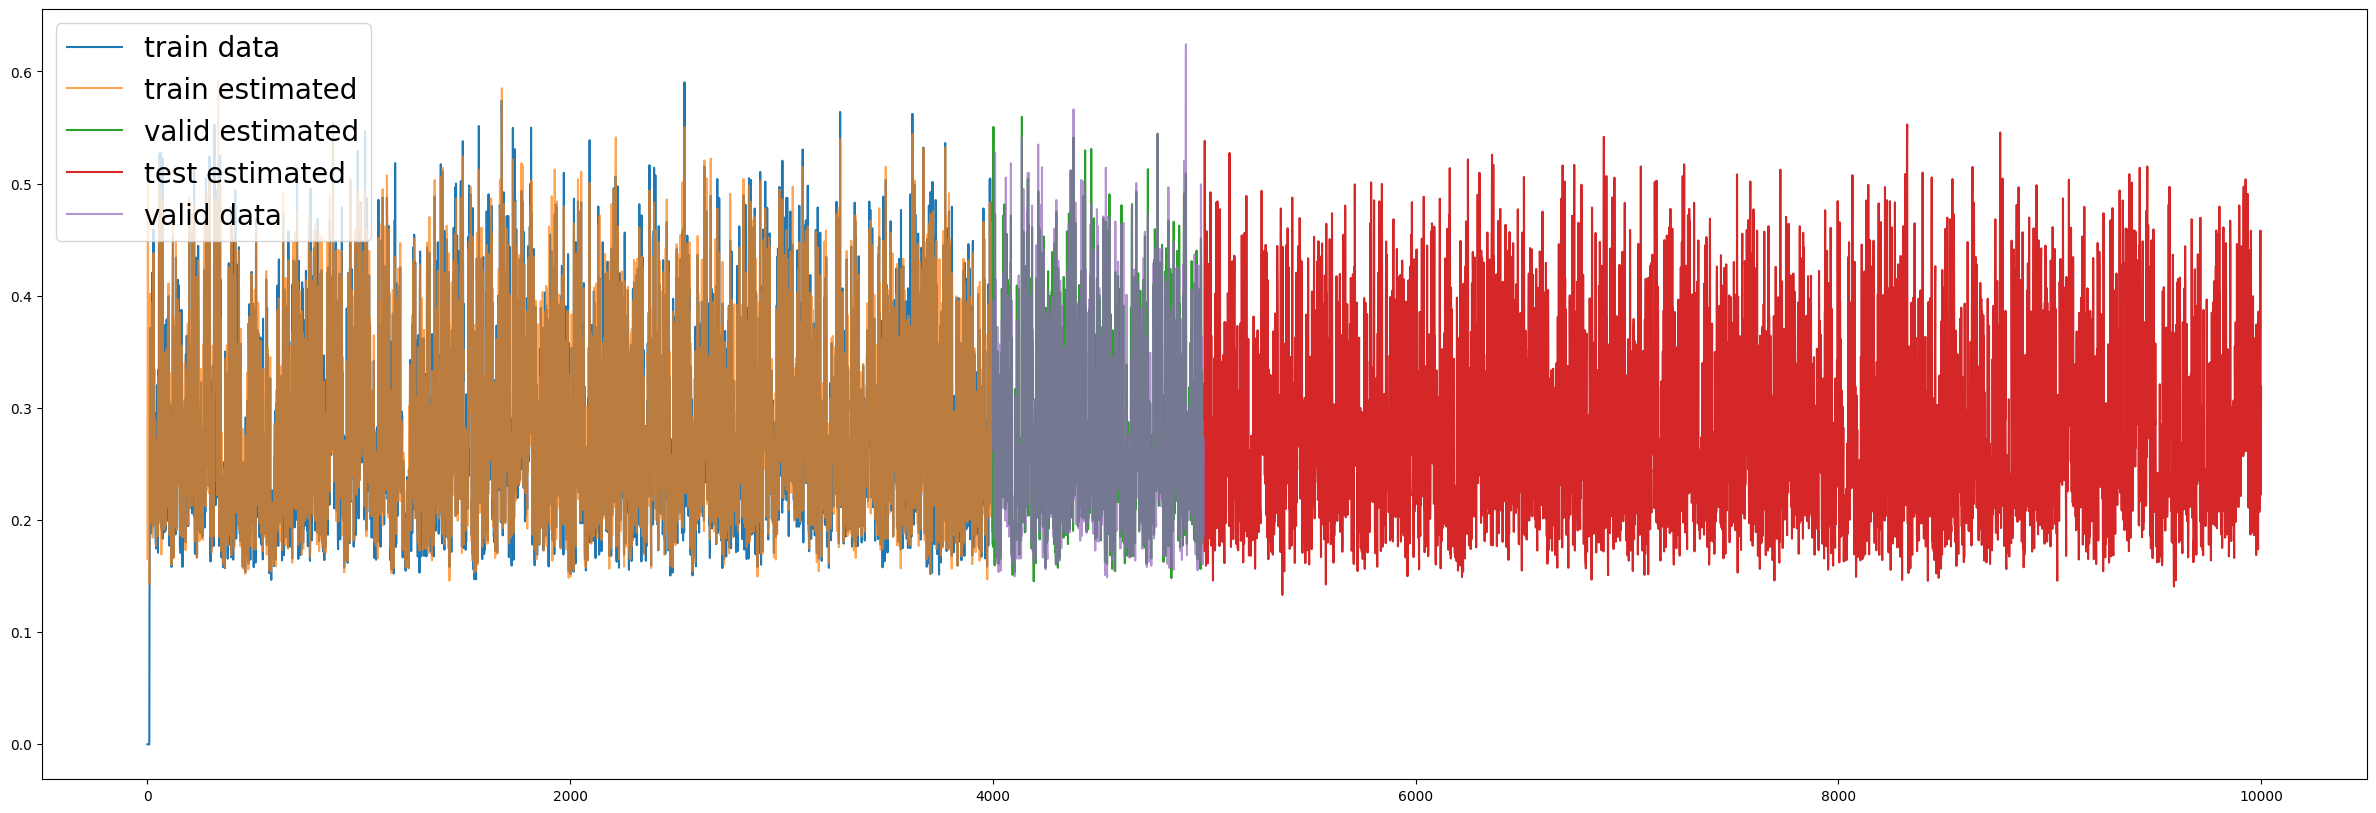

In [33]:
# get prediction for training and validation
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train, _ = rnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid, _ = rnn(valid_input_tensor)

test_input_tensor = torch.Tensor(test_input.values).unsqueeze(1).unsqueeze(2)
output_test, _ = rnn(test_input_tensor)

# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()
output_test = output_test.detach().numpy()

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
# plot only the first of the tensor
plt.plot(output_train[:,0], alpha=0.7)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])
plt.plot(np.arange(5000, 10000), output_test[:,0])
# plot output to see if valid is correct
plt.plot(valid_output, alpha=0.7)
plt.legend(['train data', 'train estimated', 'valid estimated', 'test estimated', 'valid data'], loc='upper left', fontsize=20)

# Print error for the test is
error_test = np.mean((output_test[:,0,0] - test_output)**2)
print("Error on the test is: ", error_test)
